3. Pessoas que usam crypto fazem menos churn

In [ ]:
from google.colab import auth
import pandas as pd

# get credentials
auth.authenticate_user()
query = '''
WITH users_churn AS(
  SELECT
    user_id,
    DATE_DIFF(TIMESTAMP('2019-05-16'),MAX(TIMESTAMP(transactions.created_date)), DAY) AS days_since_last_transaction,
    DATE_DIFF(TIMESTAMP('2019-05-16'),MAX(TIMESTAMP(users.created_date)), DAY) AS days_since_creation
  FROM `e-tensor-411113.neobankclean.userdevice_clean` AS users
  LEFT JOIN `e-tensor-411113.neobankclean.transactions_clean` AS transactions
  USING (user_id)
  GROUP BY user_id),

  transacoes_cripto AS (
  SELECT distinct user_id
  FROM `e-tensor-411113.neobankclean.transactions_clean`
  WHERE transactions_currency IN ('LTC','XRP','ETH','BTC','BCH'))


SELECT
  u.user_id,
  CASE
    WHEN days_since_last_transaction >= 180 AND days_since_creation >=180 THEN 'churner'
  ELSE 'not churner'
END AS churner,
CASE
  WHEN t.user_id IS NULL THEN 'not crypto user'
  ELSE 'crypto user'
END AS crypto_user

FROM users_churn u
LEFT JOIN transacoes_cripto t
  ON u.user_id = t.user_id
'''

df = pd.read_gbq(query, project_id="neural-tangent-411113")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17512 entries, 0 to 17511
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      17512 non-null  object
 1   churner      17512 non-null  object
 2   crypto_user  17512 non-null  object
dtypes: object(3)
memory usage: 410.6+ KB


In [ ]:
pivot = pd.pivot_table(df,
                       values=['churner','crypto_user'],
                       index=['churner'], columns=['crypto_user'], aggfunc='count',
                       dropna=True)

In [ ]:
pivot

user_id                
crypto_user crypto user not crypto user
churner                                
churner              44            2768
not churner         693           14007

In [ ]:
# 44/2812 ~= 1.6%
# dentre os churners, 98.4% são not crypto users

# 693/14700 ~= 4.7%
# dentre os not churners, 95.3% não são crypto users

HO: Não há relação entre crypto users e churners

H1: Há relação entre crypto users e churners

In [ ]:
import scipy.stats as stats

# Teste Chi quadrado
chi_res = stats.chi2_contingency(pivot)

print(f'p-value: {chi_res[1]}')

p-value: 3.735787746721032e-14




*   0 <= p-value <= 1
*   Se p-value < valor de significância: H0 é rejeitada
*   Fixando o valor de significância em 0.05 (valor comumente usado na literatura), temos:
*   p-value < 0.05: H0 rejeitada ⇒ H1 aceita




# Aprofundamento da análise: segmentação por idade

In [ ]:
from google.colab import auth
import pandas as pd

# get credentials
auth.authenticate_user()
query = '''
WITH users_churn AS(
  SELECT
    user_id,
    DATE_DIFF(TIMESTAMP('2019-05-16'),MAX(TIMESTAMP(transactions.created_date)), DAY) AS days_since_last_transaction,
    DATE_DIFF(TIMESTAMP('2019-05-16'),MAX(TIMESTAMP(users.created_date)), DAY) AS days_since_creation
 FROM `e-tensor-411113.neobankclean.userdevice_clean` AS users
  LEFT JOIN `e-tensor-411113.neobankclean.transactions_clean` AS transactions
  USING (user_id)
  GROUP BY user_id),

  transacoes_cripto AS (
  SELECT distinct user_id
  FROM `e-tensor-411113.neobankclean.transactions_clean`
  WHERE transactions_currency IN ('LTC','XRP','ETH','BTC','BCH'))


SELECT
  u.user_id,
  CASE
    WHEN days_since_last_transaction >= 180 AND days_since_creation >=180 THEN 'churner'
  ELSE 'not churner'
END AS churner,
CASE
  WHEN t.user_id IS NULL THEN 'not crypto user'
  ELSE 'crypto user'
END AS crypto_user,
DATE_DIFF(DATE '2019-05-16', DATE(CONCAT(users.birth_year,'-01-01')),YEAR) AS age

FROM users_churn u
LEFT JOIN transacoes_cripto t
  ON u.user_id = t.user_id

LEFT JOIN `neo_bank.users_cleaned1` users
  ON users.user_id = u.user_id
'''

df = pd.read_gbq(query, project_id="neural-tangent-411113")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17512 entries, 0 to 17511
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      17512 non-null  object
 1   churner      17512 non-null  object
 2   crypto_user  17512 non-null  object
 3   age          17512 non-null  Int64 
dtypes: Int64(1), object(3)
memory usage: 564.5+ KB


In [ ]:
df.drop(columns='user_id')

,churner,crypto_user,age
0,churner,not crypto user,90
1,churner,not crypto user,89
2,not churner,not crypto user,85
3,churner,not crypto user,85
4,churner,not crypto user,85
...,...,...,...
17507,not churner,not crypto user,18
17508,not churner,not crypto user,18
17509,not churner,not crypto user,18
17510,not churner,not crypto user,18


<Axes: xlabel='age', ylabel='Count'>

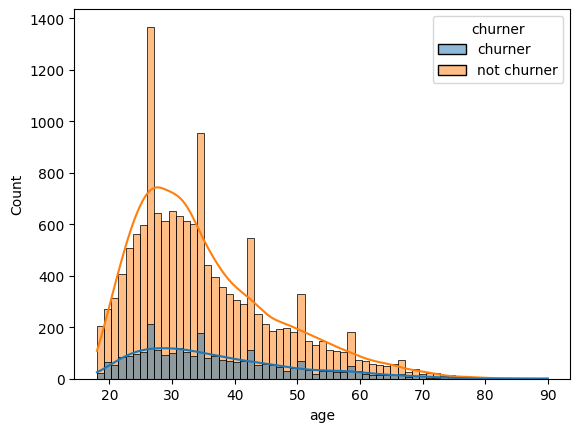

In [ ]:
import seaborn as sns

sns.histplot(data=df, x='age', hue='churner', kde=True)

<Axes: xlabel='age', ylabel='Count'>

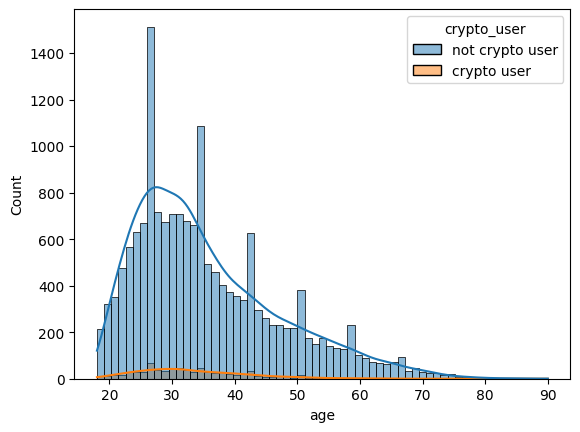

In [ ]:
sns.histplot(data=df, x='age', hue='crypto_user', kde=True)